## Kaggle Competition: Histopathologic Cancer Detection

In [1]:
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from src.data import train_test_split, get_image_dataloaders, display_image_batch
from src.model import get_resnet18
from src.train import train_model

### Prep-processing; only needs to be run once

Assumes there is a directory 'data' with a sub-directory 'train_all' that contains the unzipped 'train.zip'

In [2]:
train_test_split('data/train_labels.csv', 'data')

Training directory 'train' already exists, recreating it in 5 seconds...
Training directory 'validate' already exists, recreating it in 5 seconds...
Splitting the files from train_all/ into train/ and validate/ ...
Successfully copied 50000 files
Successfully copied 100000 files
Successfully copied 150000 files
Successfully copied 200000 files
Finished splitting the input files!


### Load the data

In [3]:
DATA_DIR = 'data/'
params = {
    "batch_size": 256,  # Increasing this will yield a CUDA Out-Of-Memory exception
    "shuffle": True,
    "num_workers": 8
}
dataloaders = get_image_dataloaders(DATA_DIR, **params)

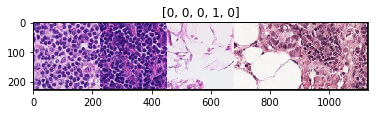

In [4]:
# Display training data

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:5])
display_image_batch(out, title=classes[:5].tolist())

### Prepare the model and training conditions

In [ ]:
model_ft = get_resnet18()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Display model layers
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Train the model

In [ ]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
